# Milestone 1

It is time to start using what you have learned throughout the first half of this course by developing an original data mining project. This week you will develop the project idea and do some data exploration/graphical analysis. You will continue working on and updating this project for the remainder of the term. The following link includes a sample project completed in Jupyter Notebook: Titanic Model Building Project Sample.

The first step is coming up with an idea – arguably one of the hardest steps! Identify an original business problem for your project that can be solved with an appropriate model. By a business problem, it is meant that you should work on a problem where there is a good reason to solve it. There should be some organization or company that would find the solution to the problem useful. There are lots of ideas available online through Kaggle and other sources, but your idea should have a unique spin on it. The second step is locating your data. This can come from a variety of sources, e.g., Kaggle, your job, a website, API, etc. Feel free to reach out to your instructor if you are not sure if your idea and data are suitable. You may need to adjust your idea on the availability of data.

Begin Milestone 1 with a 250-500-word narrative describing your original idea for the analysis/model building business problem. Clearly identify the problem you will address and the target for your model. Then, do a graphical analysis creating a minimum of four graphs. Label your graphs appropriately and explain/analyze the information provided by each graph. Your analysis should begin to answer the question(s) you are addressing. Write a short overview/conclusion of the insights gained from your graphical analysis.

As a reminder, Teams is a great place to discuss your project with your peers. Feel free to solicit feedback/input (without creating a group project!) and collaborate on your projects with your peers. Each milestone will build on top of each other, so make sure you do not fall behind.

Project Milestone 1 is due by 11:59 PM on Sunday of Week 6. I recommend building your project milestones in a Jupyter Notebook, building upon one another.

**1. Importing the dependencies**

In [540]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import plotly.figure_factory as ff
import plotly.graph_objects as go
import pickle
import warnings
from IPython.display import Markdown, display
warnings.filterwarnings("ignore")

In [541]:
# display all columns of a dataframe
pd.set_option('display.max_columns', None)

**2. Data Loading & Understanding**

In [542]:
# read the csv data to a pandas dataframe
df = pd.read_csv("./project-data/aut.csv")
test = pd.read_csv("./project-data/test.csv")
# df = pd.read_csv("./project-data/arff.csv")

### Shape of data
- df data: This will be the full data set which will be split into training and test data
- test: This will be a separate test data which will be run just for the sake to prove the accuracy of the model.

In [543]:
display(df.shape)
display(test.shape)

(800, 22)

(200, 21)

In [544]:
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,1,38.172746,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,0,47.750517,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,1,7.380373,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,0,23.561927,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,0,43.205790,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


### Look at the head of the data 

Below is the columns description of the datasets

- ID - ID of the patient
- A1_Score to A10_Score - Score based on Autism Spectrum Quotient (AQ) 10 item screening tool
- age - Age of the patient in years
- gender - Gender of the patient
- ethnicity - Ethnicity of the patient
- jaundice - Whether the patient had jaundice at the time of birth
- autism - Whether an immediate family member has been diagnosed with autism
    - contry_of_res - Country of residence of the patient
- used_app_before - Whether the patient has undergone a screening test before
- result - Score for AQ1-10 screening test
- age_desc - Age of the patient
- relation - Relation of patient who completed the test
- Class/ASD - Classified result as 0 or 1. Here 0 represents No and 1 represents Yes. This is the target column, and during submission submit the values as 0 or 1 only.

#### Check Null Values

In [545]:
display(df.isna().sum().sum())
display(test.isna().sum().sum())

0

0

In [546]:
# for col in df.columns:
#     uniq_vals  =np.unique(df[col].fillna('0'))
#     nr_values = len(uniq_vals)
#     
#     if nr_values <= 12:
#         display(Markdown(f'#### The number of values for {col} = {nr_values} which are {uniq_vals}'))
#     else:
#         display(Markdown(f'#### The number of unique values for {col} = {nr_values}'))


### Some data cleaning

In [547]:
# fix the spelling issue 
df = df.rename(columns = {'austim': 'autism', 'contry_of_res':'country_of_res'}, errors="raise")
test = test.rename(columns = {'austim': 'autism', 'contry_of_res':'country_of_res'}, errors="raise")

# fix the other/Other capitalization
df['country_of_res'][df['country_of_res'] == 'others'] = 'Others'
test['country_of_res'][test['country_of_res'] == 'others'] = 'Others'

df['ethnicity'][df['ethnicity'] == 'others'] = 'Others'
test['ethnicity'][test['ethnicity'] == 'others'] = 'Others'

In [548]:
### Check if ID is duplicated
# df[df.duplicated('ID',keep=False) == True].head()

In [549]:
# convert age column datatype to integer
df["age"] = df["age"].astype(int)
test["age"] = test["age"].astype(int)


In [550]:
# dropping ID & age_desc column
df = df.drop(columns=["ID", "age_desc"])
test = test.drop(columns=["ID", "age_desc"])

In [551]:
numerics=['int16','int32','int64','float16','float32','float64']
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
numerical_cols = [col for col in df.columns if (df[col].dtype == 'int32' or df[col].dtype == 'int64')][0:-1]
# numerical_cols = df.select_dtypes(include=numerics).columns

ASD_pos = df[df['Class/ASD']==1]
ASD_neg = df[df['Class/ASD']==0]

In [552]:
for col in df.columns:
    if col  in categorical_cols:
        print(col, df[col].unique())
        print("-"*50)

gender ['f' 'm']
--------------------------------------------------
ethnicity ['?' 'White-European' 'Middle Eastern ' 'Pasifika' 'Black' 'Others'
 'Hispanic' 'Asian' 'Turkish' 'South Asian' 'Latino']
--------------------------------------------------
jaundice ['no' 'yes']
--------------------------------------------------
autism ['no' 'yes']
--------------------------------------------------
country_of_res ['Austria' 'India' 'United States' 'South Africa' 'Jordan'
 'United Kingdom' 'Brazil' 'New Zealand' 'Canada' 'Kazakhstan'
 'United Arab Emirates' 'Australia' 'Ukraine' 'Iraq' 'France' 'Malaysia'
 'Viet Nam' 'Egypt' 'Netherlands' 'Afghanistan' 'Oman' 'Italy'
 'AmericanSamoa' 'Bahamas' 'Saudi Arabia' 'Ireland' 'Aruba' 'Sri Lanka'
 'Russia' 'Bolivia' 'Azerbaijan' 'Armenia' 'Serbia' 'Ethiopia' 'Sweden'
 'Iceland' 'Hong Kong' 'Angola' 'China' 'Germany' 'Spain' 'Tonga'
 'Pakistan' 'Iran' 'Argentina' 'Japan' 'Mexico' 'Nicaragua' 'Sierra Leone'
 'Czech Republic' 'Niger' 'Romania' 'Cyprus' 'B

In [553]:
numerical_cols

['A1_Score',
 'A2_Score',
 'A3_Score',
 'A4_Score',
 'A5_Score',
 'A6_Score',
 'A7_Score',
 'A8_Score',
 'A9_Score',
 'A10_Score',
 'age']

In [554]:
display(df.columns)
display(test.columns)

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'autism', 'country_of_res', 'used_app_before',
       'result', 'relation', 'Class/ASD'],
      dtype='object')

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'autism', 'country_of_res', 'used_app_before',
       'result', 'relation'],
      dtype='object')

In [555]:
df.ethnicity.unique()

array(['?', 'White-European', 'Middle Eastern ', 'Pasifika', 'Black',
       'Others', 'Hispanic', 'Asian', 'Turkish', 'South Asian', 'Latino'],
      dtype=object)

In [556]:
df["ethnicity"] = df["ethnicity"].replace({"?": "Others", "others": "Others"})
df["relation"] = df["relation"].replace({"?": "Others", "others": "Others"})
test["ethnicity"] = test["ethnicity"].replace({"?": "Others", "others": "Others"})
test["relation"] = test["relation"].replace({"?": "Others", "others": "Others"})


In [557]:
#Map ? in relation to something meaningful
df["relation"] = df["relation"].replace(
    {"?": "Others",
     "Relative": "Others",
     "Parent": "Others",
     "Health care professional": "Others"}
)

test["relation"] = test["relation"].replace(
    {"?": "Others",
     "Relative": "Others",
     "Parent": "Others",
     "Health care professional": "Others"}
)

In [558]:
# define the mapping dictionary for country names
mapping = {
    "Viet Nam": "Vietnam",
    "AmericanSamoa": "United States",
    "Hong Kong": "China"
}

# replace value in the country column
df["country_of_res"] = df["country_of_res"].replace(mapping)
test["country_of_res"] = test["country_of_res"].replace(mapping)

In [559]:
df["country_of_res"].unique()

array(['Austria', 'India', 'United States', 'South Africa', 'Jordan',
       'United Kingdom', 'Brazil', 'New Zealand', 'Canada', 'Kazakhstan',
       'United Arab Emirates', 'Australia', 'Ukraine', 'Iraq', 'France',
       'Malaysia', 'Vietnam', 'Egypt', 'Netherlands', 'Afghanistan',
       'Oman', 'Italy', 'Bahamas', 'Saudi Arabia', 'Ireland', 'Aruba',
       'Sri Lanka', 'Russia', 'Bolivia', 'Azerbaijan', 'Armenia',
       'Serbia', 'Ethiopia', 'Sweden', 'Iceland', 'China', 'Angola',
       'Germany', 'Spain', 'Tonga', 'Pakistan', 'Iran', 'Argentina',
       'Japan', 'Mexico', 'Nicaragua', 'Sierra Leone', 'Czech Republic',
       'Niger', 'Romania', 'Cyprus', 'Belgium', 'Burundi', 'Bangladesh'],
      dtype=object)

In [560]:
# taget class distribution
df["Class/ASD"].value_counts()

Class/ASD
0    639
1    161
Name: count, dtype: int64

**Insights:**
1. missing values in ethnicity & relation
2. age_desc column has only 1 unique value. so it is removed as it is not important for prediction
3. fixed country names
4. identified class imbalance in the target column

**3. Exploratory Data Analysis (EDA)**

In [561]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         800 non-null    int64  
 1   A2_Score         800 non-null    int64  
 2   A3_Score         800 non-null    int64  
 3   A4_Score         800 non-null    int64  
 4   A5_Score         800 non-null    int64  
 5   A6_Score         800 non-null    int64  
 6   A7_Score         800 non-null    int64  
 7   A8_Score         800 non-null    int64  
 8   A9_Score         800 non-null    int64  
 9   A10_Score        800 non-null    int64  
 10  age              800 non-null    int32  
 11  gender           800 non-null    object 
 12  ethnicity        800 non-null    object 
 13  jaundice         800 non-null    object 
 14  autism           800 non-null    object 
 15  country_of_res   800 non-null    object 
 16  used_app_before  800 non-null    object 
 17  result          

In [562]:
df.describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
count,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.560000,0.530000,0.450000,0.41500,0.395000,0.303750,0.397500,0.508750,0.495000,0.617500,27.963750,8.537303,0.201250
std,0.496697,0.499411,0.497805,0.49303,0.489157,0.460164,0.489687,0.500236,0.500288,0.486302,16.329827,4.807676,0.401185
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-6.137748,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,5.306575,0.000000
50%,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,24.000000,9.605299,0.000000
75%,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.250000,12.514484,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.000000,15.853126,1.000000


**Univariate Analysis**

Numerical Columns:
- age
- result

In [563]:
# set the desired theme
sns.set_theme(style="darkgrid")

Distribution Plots

Mean: 27.96375
Median: 24.0


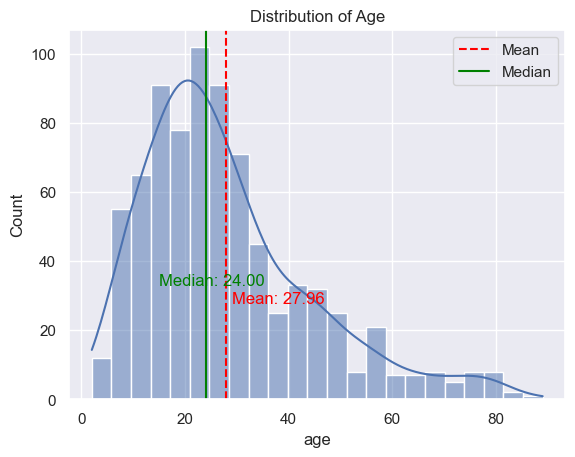

In [564]:
# Histogram for "age"

sns.histplot(df["age"], kde=True)
plt.title("Distribution of Age")

# calculate mean and median
age_mean = df["age"].mean()
age_median = df["age"].median()

print("Mean:", age_mean)
print("Median:", age_median)


# add vertical lines for mean and median
plt.axvline(age_mean, color="red", linestyle="--", label="Mean")
plt.text(age_mean + 1, age_mean, f'Mean: {age_mean:.2f}', color='red', fontsize=12)
plt.axvline(age_median, color="green", linestyle="-", label="Median")
plt.text(age_median - 9, age_mean + 5, f'Median: {age_median:.2f}', color='green', fontsize=12)
plt.legend()

plt.show()

Mean: 8.537303106501248
Median: 9.605299308


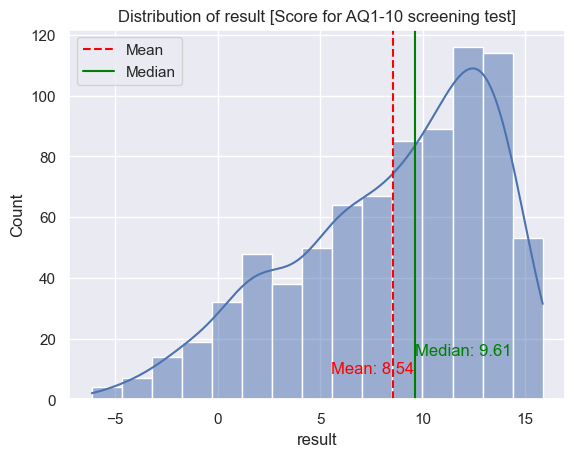

In [565]:
# Histogram for "result"(

sns.histplot(df["result"], kde=True)
plt.title("Distribution of result [Score for AQ1-10 screening test]")

# calculate mean and median
result_mean = df["result"].mean()
result_median = df["result"].median()

print("Mean:", result_mean)
print("Median:", result_median)


# add vertical lines for mean and median
plt.axvline(result_mean, color="red", linestyle="--", label="Mean")
plt.text(result_mean-3, result_mean, f'Mean: {result_mean:.2f}', color='red', fontsize=12)
plt.axvline(result_median, color="green", linestyle="-", label="Median")
plt.text(result_median, result_median+5, f'Median: {result_median:.2f}', color='green', fontsize=12)
plt.legend()

plt.show()

In [566]:
fig = px.histogram(df, x="country_of_res",
                   width=900,
                   height=400,
                   histnorm='percent',
                   template="simple_white")
fig.update_layout(title="<b> Country of Residence of the patient <b>",
                  font_family="San Serif",
                  titlefont={'size': 20},
                  legend=dict(
                      orientation="v", y=1, yanchor="top", x=1.0, xanchor="right" )
                  ).update_xaxes(categoryorder='total descending')

colors = ['lightgray',] * 100
colors[0] = 'lightseagreen'

fig.update_traces(marker_color=colors,
                  ).update_xaxes(categoryorder='total descending')

fig.show()

fig = px.treemap(df, path=['country_of_res','Class/ASD'], color='Class/ASD',
                 color_continuous_scale='teal',
                 )

fig.update_layout(#title="<b> Country of Residence of the patient<b>",
    titlefont={'size': 20, 'family': "San Serif"},
    height=500, width=1000,
    template='simple_white',
    autosize=False,
    margin=dict(l=50,r=50,b=50, t=250,
                ),
)
fig.update_layout(margin = dict(t=50, l=50, r=50, b=100))
fig.show()

### Country of Residence of the patient
- USA has the most patients in the dataset, UEA and New Zealand come in second and third.
- Only USA had equal amount of patients in both target groups (ASD_positive and ASD_negative)

In [567]:
ASD_pos.age.describe()

count    161.000000
mean      31.534161
std       17.671669
min        5.000000
25%       19.000000
50%       28.000000
75%       42.000000
max       83.000000
Name: age, dtype: float64

In [568]:
ASD_neg.age.describe()

count    639.000000
mean      27.064163
std       15.862278
min        2.000000
25%       16.000000
50%       23.000000
75%       35.000000
max       89.000000
Name: age, dtype: float64

### Age Distribution
- ASD_positive:
> average age is 31.53; the min is 5 years; and the maximum is 83 years
- ASD_negative
> average age is 27.6; the minimum is as low as 2 years; and the maximum is 89 years

Lets take a look at the Age distribution

In [569]:
group_labels = ['ASD_pos', 'ASD_neg']
fig = ff.create_distplot([ASD_pos['age'], ASD_neg['age']],
                         group_labels,
                         show_hist=True,
                         show_rug=True,
                         colors=['purple', 'salmon'],
                         )
fig.update_layout(title='<b>Age distribution<b>',
                  xaxis_title='Age',
                  yaxis_title='density',
                  titlefont={'size': 20},
                  font_family = 'San Serif',
                  width=700,height=500,
                  template="simple_white",
                  showlegend=True,
                  legend=dict(
                      orientation="v",
                      y=1,
                      yanchor="top",
                      x=1.0,
                      xanchor="right",
                  )
                  )
fig.add_vrect(
    x0=9, x1=35,
    annotation_text="Young patients", annotation_position="top",
    fillcolor="lightgray", opacity=0.5,
    layer="below", line_width=0,
),
fig.show()

### Observations

Majority of Young patients within the age of 35 are negative

In [570]:

ASD_pos_result = df[df['Class/ASD'] == 1]['result']
ASD_neg_result = df[df['Class/ASD'] == 0]['result']

fig = go.Figure()
fig.add_trace(go.Violin(x=ASD_pos_result, line_color='lightseagreen', name='ASD_positive', y0=0))
fig.add_trace(go.Violin(x=ASD_neg_result, line_color='red', name= 'ASD_negative', y0=0))

fig.update_traces(orientation='h', side='positive', meanline_visible=True)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)

fig.update_layout(title='<b> Screening test result distribution (QA1-10) <b>',
                  font_family="San Serif",
                  xaxis_title='Result',
                  titlefont={'size': 20},
                  width=600,
                  height=400,
                  template="simple_white",
                  showlegend=True,
                  )
fig.update_yaxes(showgrid=False, showline=False, showticklabels=False)
fig.show()

### Screening Test Result
- The screening test scores results are for the ASD_negative cases seems left skewed with a mean value of around 7.6
- Whereas for distribution of the ASD_positive is normally distributed.
- Higher QA test score means higher chances of being ASD_positive.

**Box plots for identifying outliers in the numerical columns**

In [571]:
numerical_cols

['A1_Score',
 'A2_Score',
 'A3_Score',
 'A4_Score',
 'A5_Score',
 'A6_Score',
 'A7_Score',
 'A8_Score',
 'A9_Score',
 'A10_Score',
 'age']

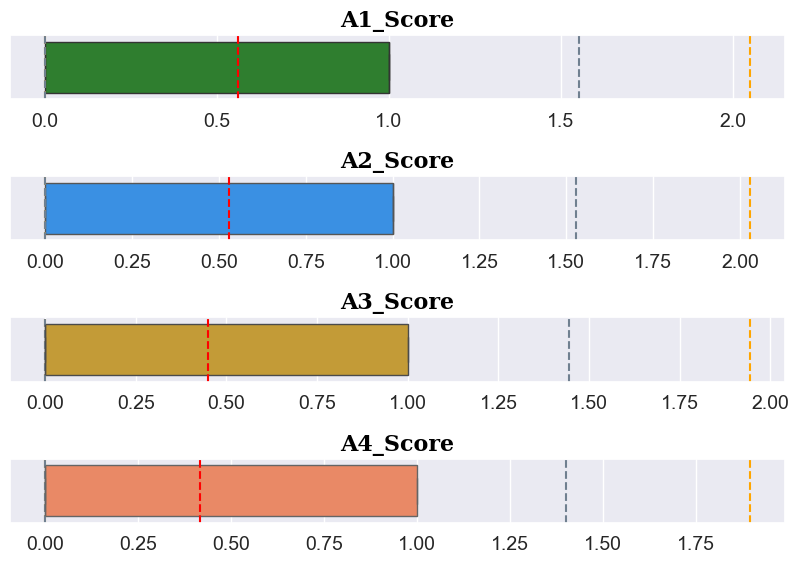

In [572]:
#create fontdict for axis labels
axlab2 = {'family': 'serif',
          'color': 'black',
          'weight': 'bold',
          'size': 16
          }
#create subplot layout
fig = plt.figure(figsize=[10,10]);
grid = plt.GridSpec(6, 1, wspace=0.3, hspace=1.2);
x = numerical_cols[:4];
col = ['forestgreen','dodgerblue','goldenrod', 'coral'];
#loop to populate boxplots within subplots
for i in np.arange(0,4):
    for j in np.arange(0,1):
        exec(f'ax{i}{j} = plt.subplot(grid[i,j]);')
        exec(f'sns.boxplot(x=df[x[{i}]], ax=ax{i}{j}, color=col[{i}]);')
        exec(f'ax{i}{j}.set_title(x[{i}], fontdict=axlab2);')
        
        exec(f'ax{i}{j}.set_xlabel("", fontdict=axlab2);')
        exec(f'a{i} = ax{i}{j}.axvline(df[x[{i}]].mean(),color= "red", linestyle="--", label="mean")')
        exec(f'b{i} = ax{i}{j}.axvline(df[x[{i}]].mean()+ 3 * df[x[{i}]].std(),color= "orange", linestyle="--", label="3sigma")')
        exec(f'ax{i}{j}.axvline(max([df[x[{i}]].mean()- 3 * df[x[{i}]].std(), 0]),color= "orange", linestyle="--")')
        exec(f'c{i} = ax{i}{j}.axvline(df[x[{i}]].mean()+ 2 * df[x[{i}]].std(),color= "slategrey", linestyle="--", label="2sigma")')
        exec(f'ax{i}{j}.axvline(max([df[x[{i}]].mean()- 2 * df[x[{i}]].std(), 0]),color= "slategrey", linestyle="--")')
        plt.xticks(fontsize=14);

plt.show();


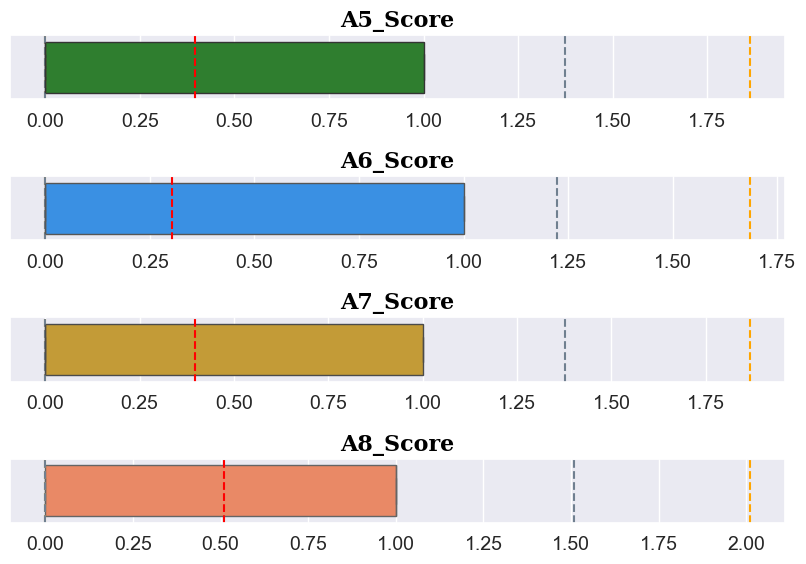

In [573]:
#create fontdict for axis labels
axlab2 = {'family': 'serif',
          'color': 'black',
          'weight': 'bold',
          'size': 16
          }
#create subplot layout
fig = plt.figure(figsize=[10,10]);
grid = plt.GridSpec(6, 1, wspace=0.3, hspace=1.2);
x = numerical_cols[4:8];
col = ['forestgreen','dodgerblue','goldenrod', 'coral'];
#loop to populate boxplots within subplots
for i in np.arange(0,4):
    for j in np.arange(0,1):
        exec(f'ax{i}{j} = plt.subplot(grid[i,j]);')
        exec(f'sns.boxplot(x=df[x[{i}]], ax=ax{i}{j}, color=col[{i}]);')
        exec(f'ax{i}{j}.set_title(x[{i}], fontdict=axlab2);')

        exec(f'ax{i}{j}.set_xlabel("", fontdict=axlab2);')
        exec(f'a{i} = ax{i}{j}.axvline(df[x[{i}]].mean(),color= "red", linestyle="--", label="mean")')
        exec(f'b{i} = ax{i}{j}.axvline(df[x[{i}]].mean()+ 3 * df[x[{i}]].std(),color= "orange", linestyle="--", label="3sigma")')
        exec(f'ax{i}{j}.axvline(max([df[x[{i}]].mean()- 3 * df[x[{i}]].std(), 0]),color= "orange", linestyle="--")')
        exec(f'c{i} = ax{i}{j}.axvline(df[x[{i}]].mean()+ 2 * df[x[{i}]].std(),color= "slategrey", linestyle="--", label="2sigma")')
        exec(f'ax{i}{j}.axvline(max([df[x[{i}]].mean()- 2 * df[x[{i}]].std(), 0]),color= "slategrey", linestyle="--")')
        plt.xticks(fontsize=14);

plt.show();

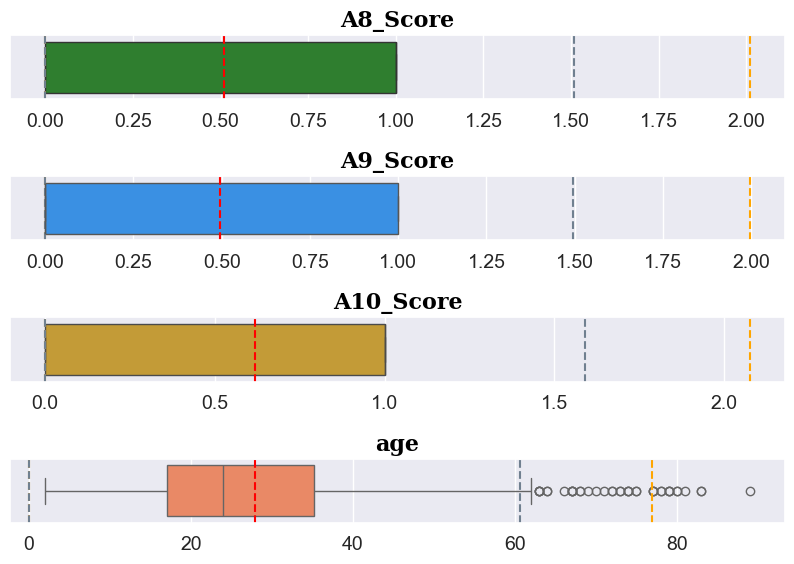

In [574]:
#create fontdict for axis labels
axlab2 = {'family': 'serif',
          'color': 'black',
          'weight': 'bold',
          'size': 16
          }
#create subplot layout
fig = plt.figure(figsize=[10,10]);
grid = plt.GridSpec(6, 1, wspace=0.3, hspace=1.2);
x = numerical_cols[-4:];
col = ['forestgreen','dodgerblue','goldenrod', 'coral'];
#loop to populate boxplots within subplots
for i in np.arange(0,4):
    for j in np.arange(0,1):
        exec(f'ax{i}{j} = plt.subplot(grid[i,j]);')
        exec(f'sns.boxplot(x=df[x[{i}]], ax=ax{i}{j}, color=col[{i}]);')
        exec(f'ax{i}{j}.set_title(x[{i}], fontdict=axlab2);')

        exec(f'ax{i}{j}.set_xlabel("", fontdict=axlab2);')
        exec(f'a{i} = ax{i}{j}.axvline(df[x[{i}]].mean(),color= "red", linestyle="--", label="mean")')
        exec(f'b{i} = ax{i}{j}.axvline(df[x[{i}]].mean()+ 3 * df[x[{i}]].std(),color= "orange", linestyle="--", label="3sigma")')
        exec(f'ax{i}{j}.axvline(max([df[x[{i}]].mean()- 3 * df[x[{i}]].std(), 0]),color= "orange", linestyle="--")')
        exec(f'c{i} = ax{i}{j}.axvline(df[x[{i}]].mean()+ 2 * df[x[{i}]].std(),color= "slategrey", linestyle="--", label="2sigma")')
        exec(f'ax{i}{j}.axvline(max([df[x[{i}]].mean()- 2 * df[x[{i}]].std(), 0]),color= "slategrey", linestyle="--")')
        plt.xticks(fontsize=14);

plt.show();

In [575]:
# count the outliers using IQR method
Q1 = df["age"].quantile(0.25)
Q3 = df["age"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
age_outliers = df[(df["age"] < lower_bound) | (df["age"] > upper_bound)]
len(age_outliers)

39

In [576]:
# count the outliers using IQR method
Q1 = df["result"].quantile(0.25)
Q3 = df["result"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
result_outliers = df[(df["result"] < lower_bound) | (df["result"] > upper_bound)]
len(result_outliers)

1

Univariate analysis of Categorical columns

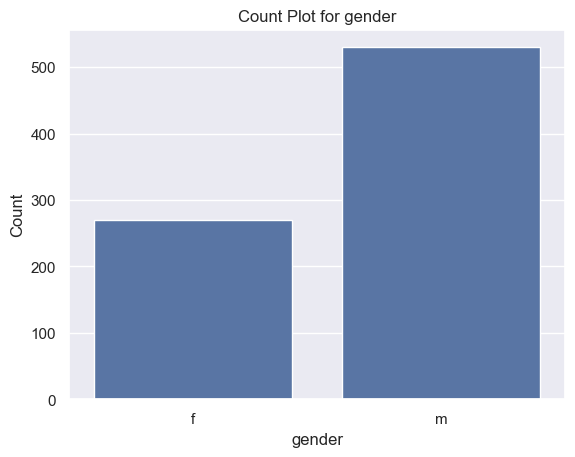

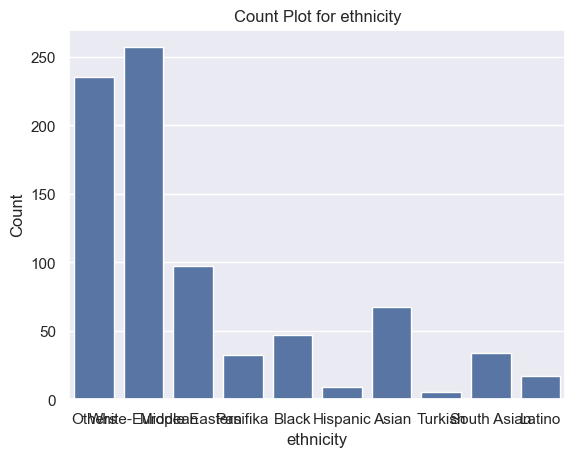

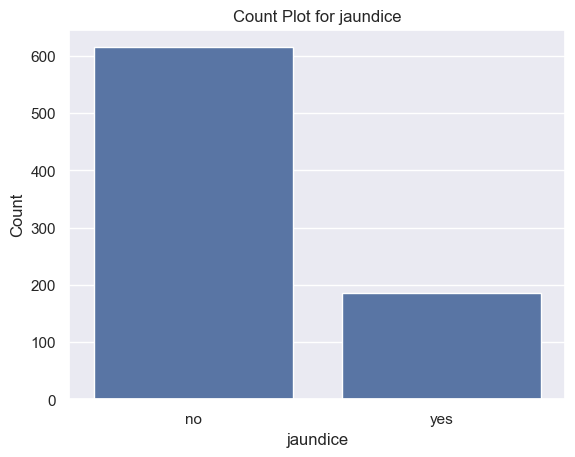

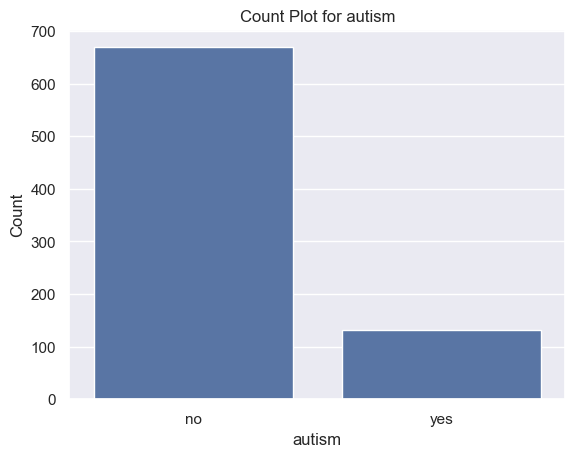

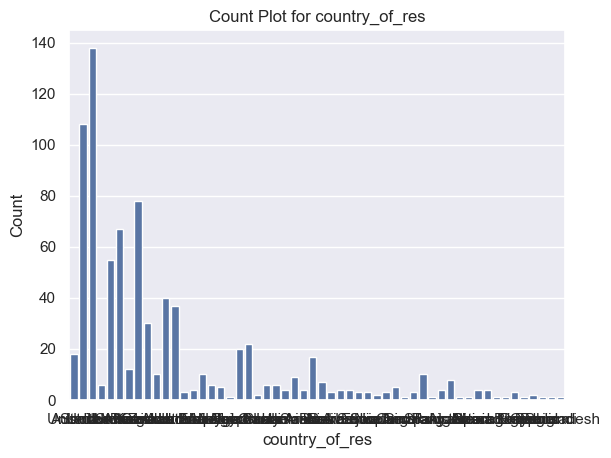

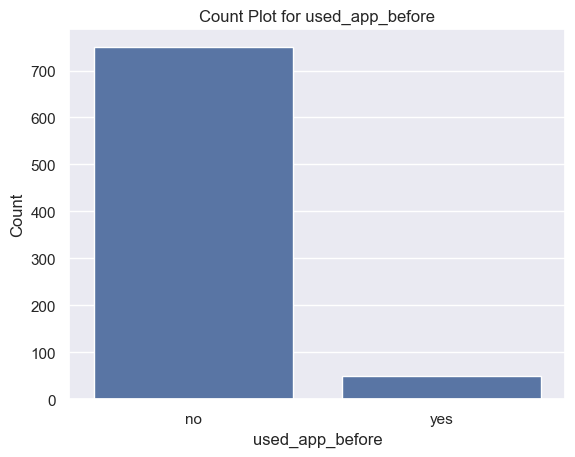

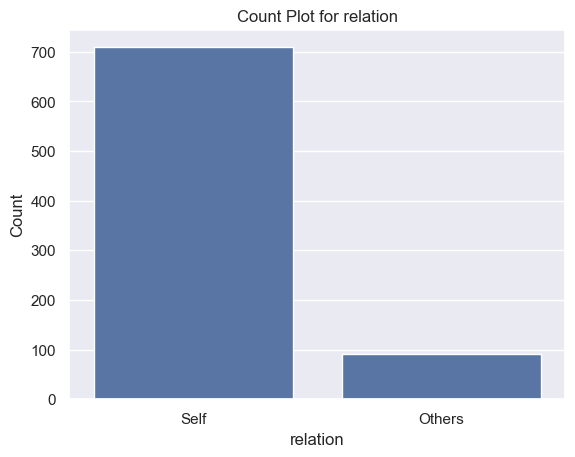

In [577]:
for col in categorical_cols:
  sns.countplot(x=df[col])
  plt.title(f"Count Plot for {col}")
  plt.xlabel(col)
  plt.ylabel("Count")
  plt.show()

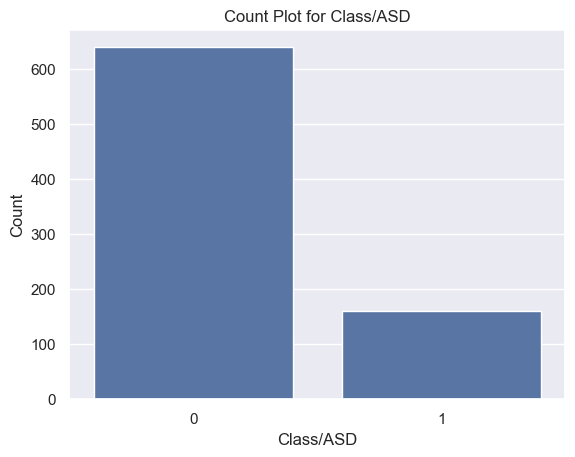

In [578]:
# countplot for target column (Class/ASD)
sns.countplot(x=df["Class/ASD"])
plt.title("Count Plot for Class/ASD")
plt.xlabel("Class/ASD")
plt.ylabel("Count")
plt.show()

In [579]:
df["Class/ASD"].value_counts()

Class/ASD
0    639
1    161
Name: count, dtype: int64

handle missing values in ethnicity and relation column

In [580]:
df_before_encoding=df.copy()
test_before_encoding=test.copy()
display(df_before_encoding.shape)
display(test_before_encoding.shape)

(800, 20)

(200, 19)

**Label Encoding**

In [581]:
# identify columns with "object" data type
object_columns = df.select_dtypes(include=["object"]).columns
print(object_columns)

Index(['gender', 'ethnicity', 'jaundice', 'autism', 'country_of_res',
       'used_app_before', 'relation'],
      dtype='object')


In [582]:
# initialize a dictionary to store the encoders
encoders = {}

# apply label encoding and store the encoders
for column in object_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  test[column] =label_encoder.fit_transform(test[column])
  encoders[column] = label_encoder   

# 
# # save the encoders as a pickle file
# with open("./project-data/encoders.pkl", "wb") as f:
#   pickle.dump(encoders, f)

In [583]:
encoders

{'gender': LabelEncoder(),
 'ethnicity': LabelEncoder(),
 'jaundice': LabelEncoder(),
 'autism': LabelEncoder(),
 'country_of_res': LabelEncoder(),
 'used_app_before': LabelEncoder(),
 'relation': LabelEncoder()}

## Object Columns Before Encoding

In [584]:
df_before_encoding[object_columns].head()

,gender,ethnicity,jaundice,autism,country_of_res,used_app_before,relation
0,f,Others,no,no,Austria,no,Self
1,m,Others,no,no,India,no,Self
2,m,White-European,no,yes,United States,no,Self
3,f,Others,no,no,United States,no,Self
4,m,Others,no,no,South Africa,no,Self


## Object Columns After Encoding

In [585]:
df[object_columns].head()

,gender,ethnicity,jaundice,autism,country_of_res,used_app_before,relation
0,0,5,0,0,6,0,1
1,1,5,0,0,23,0,1
2,1,9,0,1,52,0,1
3,0,5,0,0,52,0,1
4,1,5,0,0,44,0,1


Bivariate Analysis

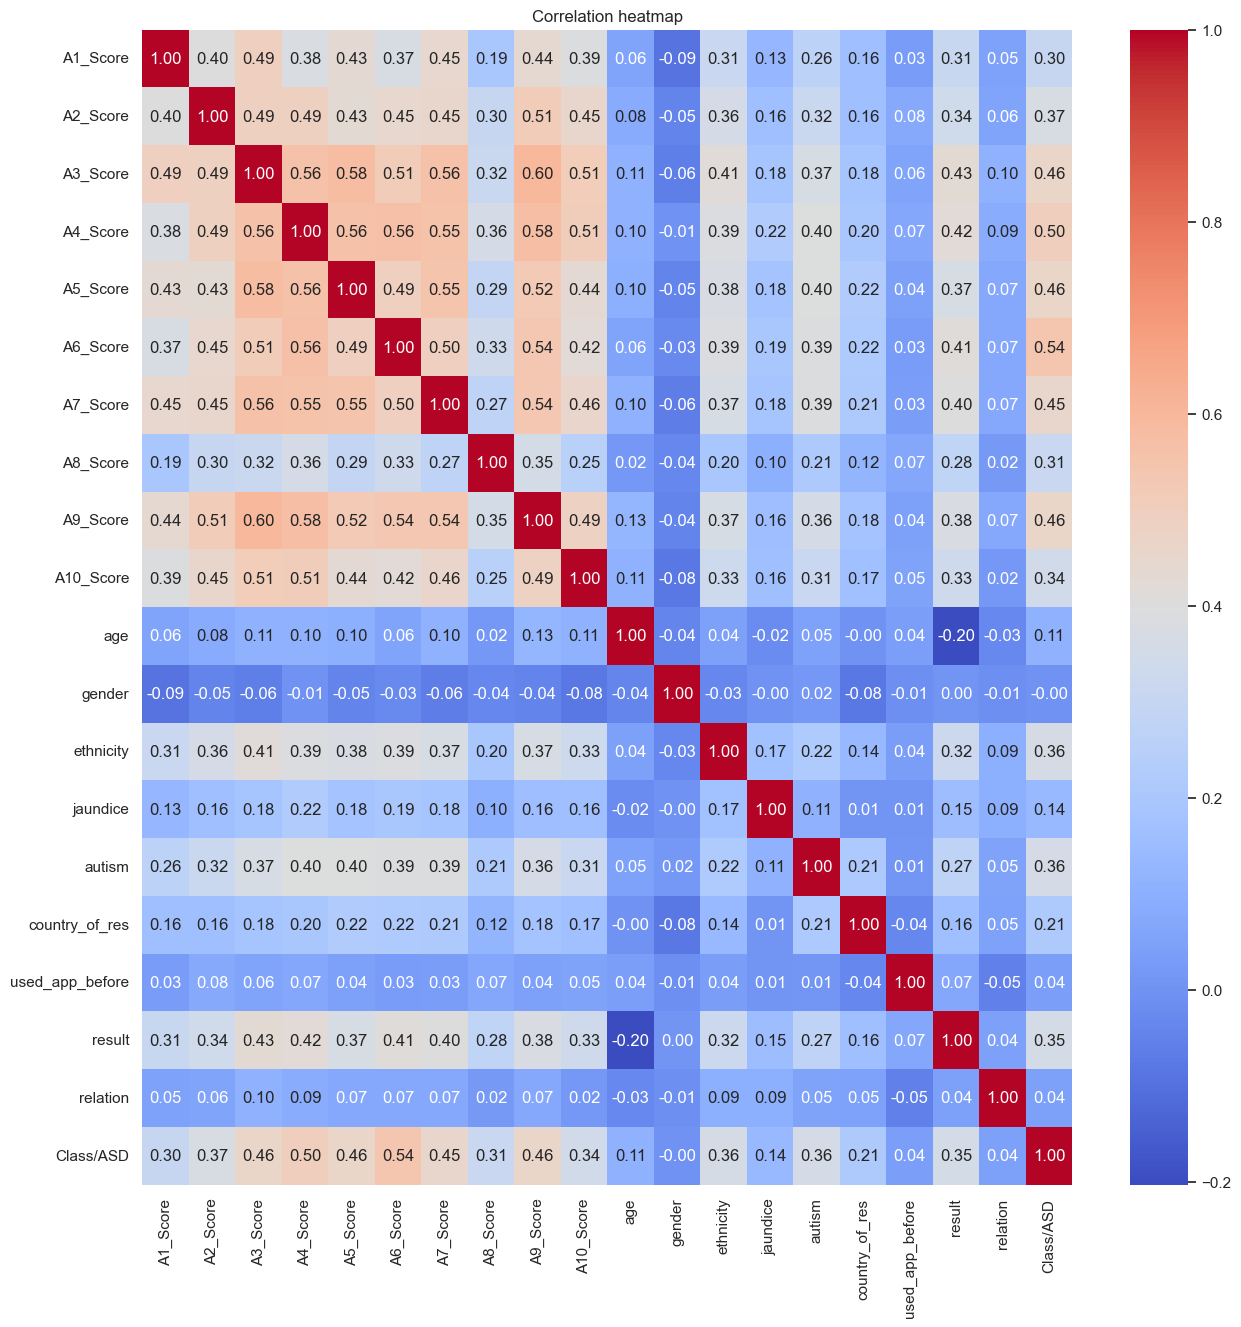

In [586]:
# correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation heatmap")
plt.show()

In [587]:
df.corr()['Class/ASD'].sort_values(ascending=False)[1:]

A6_Score           0.543010
A4_Score           0.501046
A9_Score           0.463347
A5_Score           0.461773
A3_Score           0.460927
A7_Score           0.452338
A2_Score           0.372740
ethnicity          0.364388
autism             0.359217
result             0.351906
A10_Score          0.343736
A8_Score           0.312388
A1_Score           0.300474
country_of_res     0.211683
jaundice           0.138784
age                0.109817
relation           0.042358
used_app_before    0.037835
gender            -0.004368
Name: Class/ASD, dtype: float64

**Insights from EDA:**

- There are few outliers in the numerical columns (age, results)
- There is a class imbalance in the target column
- There is a class imbalance in the categorical features
- We can see that A6_Score and A4_Score has the highest correlation with result, which implies that they have the highest say in determining whether the person has Autism or not.
- performed label encoding and saved the encoders

**4. Data preprocessing**

Handling teh outliers

In [588]:
# function to replace the outliers with median
def replace_outliers_with_median(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  median = df[column].median()

  # replace outliers with median value
  df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)

  return df

In [589]:
# replace outliers in the "age" column
df = replace_outliers_with_median(df, "age")

# replace outliers in the "result" column
df = replace_outliers_with_median(df, "result")

In [590]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,autism,country_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38.0,0,5,0,0,6,0,6.351166,1,0
1,0,0,0,0,0,0,0,0,0,0,47.0,1,5,0,0,23,0,2.255185,1,0
2,1,1,1,1,1,1,1,1,1,1,7.0,1,9,0,1,52,0,14.851484,1,1
3,0,0,0,0,0,0,0,0,0,0,23.0,0,5,0,0,52,0,2.276617,1,0
4,0,0,0,0,0,0,0,0,0,0,43.0,1,5,0,0,44,0,-4.777286,1,0


In [591]:
df.shape

(800, 20)

**Train Test Split**

In [592]:
X = df.drop(columns=["Class/ASD"])
y = df["Class/ASD"]

In [593]:
print(X)

     A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0           1         0         1         0         1         0         1   
1           0         0         0         0         0         0         0   
2           1         1         1         1         1         1         1   
3           0         0         0         0         0         0         0   
4           0         0         0         0         0         0         0   
..        ...       ...       ...       ...       ...       ...       ...   
795         0         1         0         0         0         0         0   
796         0         1         1         0         0         1         0   
797         0         0         0         0         0         0         0   
798         0         0         0         0         0         0         0   
799         0         1         0         0         0         0         0   

     A8_Score  A9_Score  A10_Score   age  gender  ethnicity  jaundice  auti

In [594]:
print(y)

0      0
1      0
2      1
3      0
4      0
      ..
795    0
796    0
797    0
798    0
799    0
Name: Class/ASD, Length: 800, dtype: int64


In [595]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [596]:
print(X_train.shape)
print(y_test.shape)

(640, 19)
(160,)


In [597]:
y_train.value_counts()

Class/ASD
0    515
1    125
Name: count, dtype: int64

In [598]:
y_test.value_counts()

Class/ASD
0    124
1     36
Name: count, dtype: int64

**SMOTE (Synthetic Minority Oversampling technique)**

In [599]:
smote = SMOTE(random_state=42)

In [600]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [601]:
X_train_smote.shape

(1030, 19)

In [602]:
y_train_smote.shape

(1030,)

In [603]:
y_train_smote.value_counts()

Class/ASD
1    515
0    515
Name: count, dtype: int64

In [604]:
accuracy_list = []
f1_list = []
roc_auc_list = []

In [605]:
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score,RocCurveDisplay

def  process_all_model_scores(local_model,local_x_train,local_y_train,local_x_test,local_y_test):

    #fit on data
    local_model.fit(local_x_train, local_y_train)

    #prediction
    pred_output = local_model.predict(local_x_test)

    #performance of model
    print("Classification Report: \n", classification_report(local_y_test, pred_output))
    print("-" * 100)
    print()

    #accuracy of model
    acc = accuracy_score(local_y_test, pred_output)
    accuracy_list.append(acc)
    print("Accuracy Score: ", acc)
    print("-" * 100)
    print()

    #f1-score of model
    f1 = f1_score(local_y_test, pred_output)
    f1_list.append(f1)
    print("F1 Score: ", f1)
    print("-" * 100)
    print()

    #roc-auc curve of model
    fpr,tpr,threshold = roc_curve(local_y_test,pred_output)
    auc_value = auc(fpr,tpr)
    rocauc_score = roc_auc_score(local_y_test, pred_output)
    roc_auc_list.append(rocauc_score)
    plt.figure(figsize=(5,5),dpi=100)
    print("ROC-AUC Score: ", f1)
    print("-" * 100)
    print()
    plt.plot(fpr,tpr,linestyle='-',label = "(auc_value = %0.3f)" % auc_value)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print()
    
    #roccurvedisplay
    plt.figure(figsize=(5,5),dpi=100)
    RocCurveDisplay.from_estimator(local_model, local_x_test, local_y_test)
    plt.title('ROC_AUC curve')
    plt.legend()
    plt.show()
    print()

    #confusion matrix for model
    print("Confusion Matrix: ")
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(local_y_test, pred_output), annot=True, fmt='g');
    plt.title('Confusion Matrix', fontsize=20)

### **5. Model Training**

In [606]:
# dictionary of classifiers
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

In [607]:
# dictionary to store the cross validation results
cv_scores = {}

# perform 5-fold cross validation for each model
for model_name, model in models.items():
  print(f"Training {model_name} with default parameters...")
  scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring="accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} Cross-Validation Accuracy: {np.mean(scores):.2f}")
  print("-"*50)

Training Decision Tree with default parameters...
Decision Tree Cross-Validation Accuracy: 0.86
--------------------------------------------------
Training Random Forest with default parameters...
Random Forest Cross-Validation Accuracy: 0.92
--------------------------------------------------
Training XGBoost with default parameters...
XGBoost Cross-Validation Accuracy: 0.90
--------------------------------------------------


In [608]:
cv_scores

{'Decision Tree': array([0.7961165 , 0.87864078, 0.87378641, 0.8592233 , 0.87378641]),
 'Random Forest': array([0.90776699, 0.92718447, 0.9223301 , 0.91747573, 0.9223301 ]),
 'XGBoost': array([0.87378641, 0.9223301 , 0.89320388, 0.91262136, 0.91747573])}

**6. Model Selection & Hyperparameter Tuning**

In [609]:
# Initializing models
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
xgboost_classifier = XGBClassifier(random_state=42)

In [610]:
# Hyperparameter grids for RandomizedSearchCV

param_grid_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 50, 70],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}


param_grid_rf = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}


param_grid_xgb = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "subsample": [0.5, 0.7, 1.0],
    "colsample_bytree": [0.5, 0.7, 1.0]
}


In [611]:
# hyperparameter tuning for 3 tree based models

# the below steps can be automated by using a for loop or by using a pipeline

# perform RandomizedSearchCV for each model
random_search_dt = RandomizedSearchCV(estimator=decision_tree, param_distributions=param_grid_dt, n_iter=20, cv=5, scoring="accuracy", random_state=42)
random_search_rf = RandomizedSearchCV(estimator=random_forest, param_distributions=param_grid_rf, n_iter=20, cv=5, scoring="accuracy", random_state=42)
random_search_xgb = RandomizedSearchCV(estimator=xgboost_classifier, param_distributions=param_grid_xgb, n_iter=20, cv=5, scoring="accuracy", random_state=42)


In [612]:
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.5.2

In [613]:
# fit the models
random_search_dt.fit(X_train_smote, y_train_smote)
random_search_rf.fit(X_train_smote, y_train_smote)
random_search_xgb.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 500],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42, scoring='accuracy')

In [614]:
# Get the model with best score

best_model = None
best_score = 0

if random_search_dt.best_score_ > best_score:
  best_model = random_search_dt.best_estimator_
  best_score = random_search_dt.best_score_

if random_search_rf.best_score_ > best_score:
  best_model = random_search_rf.best_estimator_
  best_score = random_search_rf.best_score_

if random_search_xgb.best_score_ > best_score:
  best_model = random_search_xgb.best_estimator_
  best_score = random_search_xgb.best_score_



In [615]:
print(f"Best Model: {best_model}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

Best Model: RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=50,
                       random_state=42)
Best Cross-Validation Accuracy: 0.93


In [616]:
# save the best model
# with open("./project-data/best_model.pkl", "wb") as f:
#   pickle.dump(best_model, f)

**7. Evaluation**

In [617]:
# evaluate on test data
y_test_pred = best_model.predict(X_test)
print("Accuracy score:\n", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Accuracy score:
 0.81875
Confusion Matrix:
 [[108  16]
 [ 13  23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88       124
           1       0.59      0.64      0.61        36

    accuracy                           0.82       160
   macro avg       0.74      0.75      0.75       160
weighted avg       0.82      0.82      0.82       160



In [618]:
#Not required already encoded previously
# label_encoder = LabelEncoder()
# train_le = df.copy()
# test_le = test.copy()
# 
# for col in categorical_cols:
#     df[col] = label_encoder.fit_transform(df[col])
#     test[col] = label_encoder.fit_transform(test[col])
# 
# train = train_le
# test = test_le

In [619]:
X = X_train_smote.copy()
y = y_train_smote.copy()

seed = 0
fold = 5

In [620]:
from sklearn.model_selection import cross_validate, StratifiedKFold


def score(X, y, model, cv):
    scoring = ["roc_auc"]
    scores = cross_validate(
        model, X, y, scoring=scoring, cv=cv, return_train_score=True,
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )

skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)

In [621]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(solver='saga',
                              tol=1e-5, max_iter=10000,
                              random_state=0,
                              C=0.22685190926977272,
                              penalty='l2',
                              )

scores = score(X, y, model_lr, cv=skf)
display(scores)

,0,1,2,3,4,mean,std
fit_time,0.603403,0.535913,0.539181,0.545575,0.506896,0.546194,0.031536
score_time,0.000000,0.002006,0.000000,0.000000,0.009625,0.002326,0.003731
test_roc_auc,0.933264,0.924404,0.903478,0.884249,0.919408,0.912961,0.017315
train_roc_auc,0.913670,0.915744,0.922642,0.924887,0.919002,0.919189,0.004165


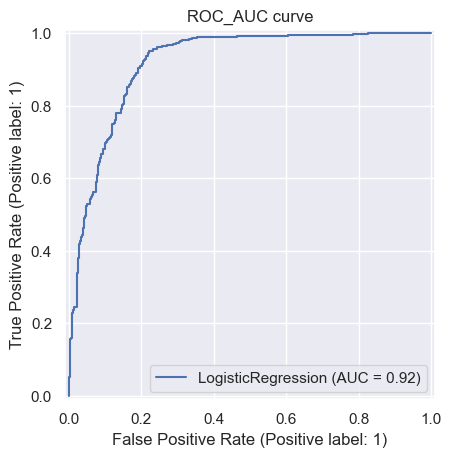

In [625]:
from sklearn import metrics

model_lr.fit(X, y)
metrics.RocCurveDisplay.from_estimator(model_lr, X, y)
plt.title('ROC_AUC curve')
plt.show();

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.82      0.88       124
           1       0.58      0.83      0.68        36

    accuracy                           0.82       160
   macro avg       0.76      0.83      0.78       160
weighted avg       0.86      0.82      0.83       160

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.825
----------------------------------------------------------------------------------------------------

F1 Score:  0.6818181818181818
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.6818181818181818
----------------------------------------------------------------------------------------------------



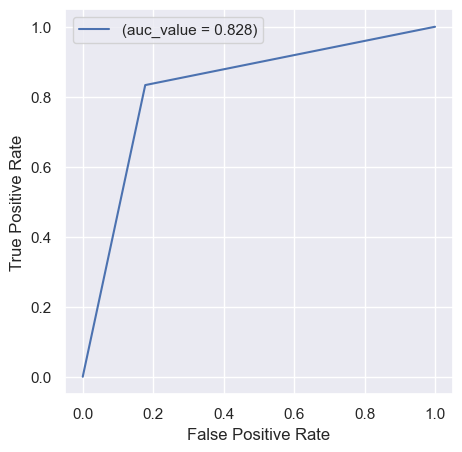

<Figure size 500x500 with 0 Axes>

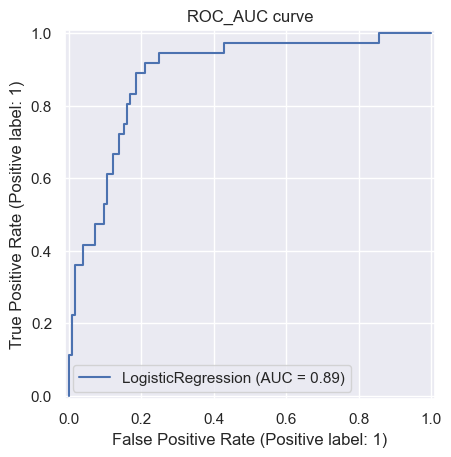


Confusion Matrix: 


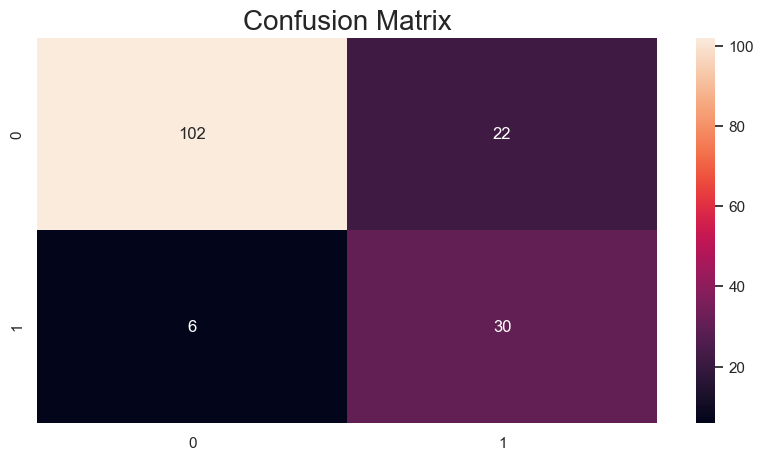

In [623]:
lr = LogisticRegression()
process_all_model_scores(local_model=lr,local_x_train=X,local_y_train=y,local_x_test=X_test,local_y_test=y_test)

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.94      0.92       124
           1       0.75      0.67      0.71        36

    accuracy                           0.88       160
   macro avg       0.83      0.80      0.81       160
weighted avg       0.87      0.88      0.87       160

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.875
----------------------------------------------------------------------------------------------------

F1 Score:  0.7058823529411765
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.7058823529411765
----------------------------------------------------------------------------------------------------



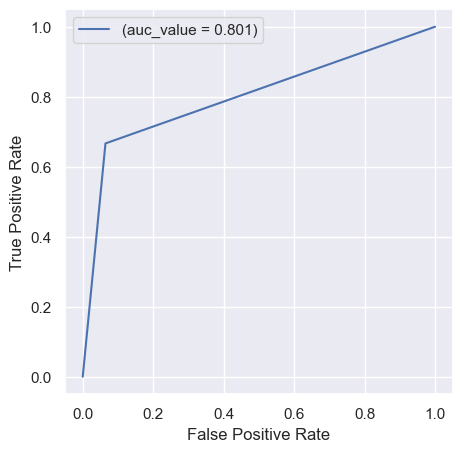

<Figure size 500x500 with 0 Axes>

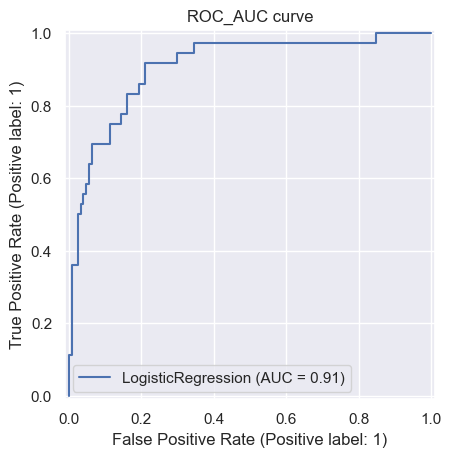


Confusion Matrix: 


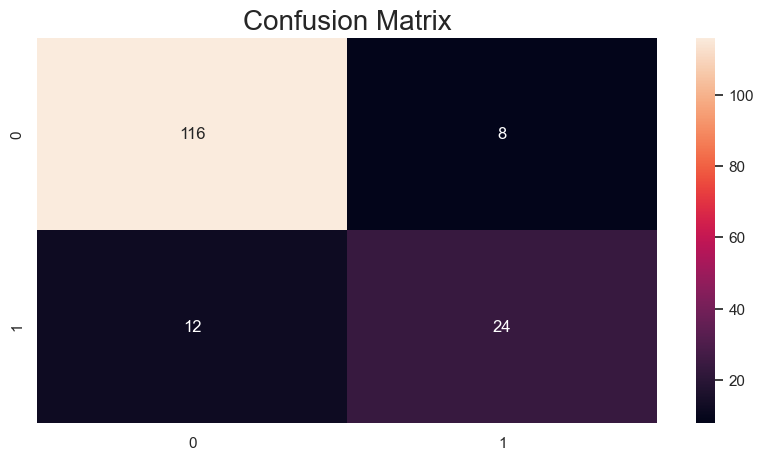

In [624]:
#Logistic model without smote data
process_all_model_scores(local_model=lr,local_x_train=X_train,local_y_train=y_train,local_x_test=X_test,local_y_test=y_test)

## The best model is 